In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load preprocessed data
df = pd.read_csv('preprocessed_reviews.csv')
df['Processed_Review'] = df['Processed_Review'].fillna('').astype(str)
X = df['Processed_Review']
y = df['Sentiment_Label']

print(f"Total samples: {len(df)}")
print(f"Positive: {sum(y==1)}, Negative: {sum(y==0)}")

Total samples: 3710
Positive: 2931, Negative: 779


In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Train size: 2968
Test size: 742


In [4]:
# Feature Extraction - TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")


TF-IDF feature matrix shape: (2968, 2227)


In [5]:
# Feature Extraction - Bag of Words
bow_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_bow = bow_vectorizer.fit_transform(X_train)

print(f"BoW feature matrix shape: {X_train_bow.shape}")

BoW feature matrix shape: (2968, 2227)


## Model Trainning

In [6]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(max_iter=1000,class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
}

In [7]:
# Trainning Models on TF-IDF and Evaluating TRAINING PERFORMANCE + CROSS VALIDATION
results_train = {}

print("="*60)
print("TRAINING PERFORMANCE + CROSS VALIDATION (TF-IDF)")
print("="*60)

for name, model in models.items():
    
    print(f"\n Training {name}...")

    # -----------------------
    # Fit on training data
    # -----------------------
    model.fit(X_train_tfidf, y_train)

    # -----------------------
    # Training score
    # -----------------------
    y_train_pred = model.predict(X_train_tfidf)
    train_f1 = f1_score(y_train, y_train_pred)

    # -----------------------
    # Cross-validation score
    # -----------------------
    cv_scores = cross_val_score(
        model,
        X_train_tfidf,
        y_train,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    # Store results
    results_train[name] = {
        'Train F1': train_f1,
        'CV Mean F1': cv_mean,
        'CV Std': cv_std
    }

    print(f"Train F1      : {train_f1:.4f}")
    print(f"CV Mean F1    : {cv_mean:.4f} (+/- {cv_std:.4f})")


# -----------------------
# Summary table
# -----------------------
results_df = pd.DataFrame(results_train).T.sort_values('CV Mean F1', ascending=False)

print("\n Training + CV Summary:")
print(results_df)

TRAINING PERFORMANCE + CROSS VALIDATION (TF-IDF)

 Training Logistic Regression...
Train F1      : 0.9611
CV Mean F1    : 0.9299 (+/- 0.0096)

 Training Naive Bayes...
Train F1      : 0.9536
CV Mean F1    : 0.9310 (+/- 0.0046)

 Training SVM...
Train F1      : 0.9795
CV Mean F1    : 0.9231 (+/- 0.0089)

 Training Random Forest...
Train F1      : 0.9957
CV Mean F1    : 0.9304 (+/- 0.0065)

 Training + CV Summary:
                     Train F1  CV Mean F1    CV Std
Naive Bayes          0.953550    0.930968  0.004639
Random Forest        0.995739    0.930351  0.006522
Logistic Regression  0.961112    0.929869  0.009605
SVM                  0.979451    0.923090  0.008909


In [8]:
## Trainning Models on BOW and Evaluating TRAINING PERFORMANCE + CROSS VALIDATION

results_train_bow = {}

print("="*60)
print("TRAINING PERFORMANCE + CROSS VALIDATION (BAG OF WORDS)")
print("="*60)

for name, model in models.items():
    
    print(f"\n Training {name}...")

    # -----------------------
    # Fit on training data
    # -----------------------
    model.fit(X_train_bow, y_train)

    # -----------------------
    # Training score
    # -----------------------
    y_train_pred = model.predict(X_train_bow)
    train_f1 = f1_score(y_train, y_train_pred)

    # -----------------------
    # Cross-validation score
    # -----------------------
    cv_scores = cross_val_score(
        model,
        X_train_bow,
        y_train,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    # Store results
    results_train_bow[name] = {
        'Train F1': train_f1,
        'CV Mean F1': cv_mean,
        'CV Std': cv_std
    }

    print(f"Train F1      : {train_f1:.4f}")
    print(f"CV Mean F1    : {cv_mean:.4f} (+/- {cv_std:.4f})")


# -----------------------
# Summary table
# -----------------------
results_bow_df = (
    pd.DataFrame(results_train_bow)
    .T
    .sort_values('CV Mean F1', ascending=False)
)

print("\n Training + CV Summary (BoW):")
print(results_bow_df)

TRAINING PERFORMANCE + CROSS VALIDATION (BAG OF WORDS)

 Training Logistic Regression...
Train F1      : 0.9728
CV Mean F1    : 0.9304 (+/- 0.0123)

 Training Naive Bayes...
Train F1      : 0.9594
CV Mean F1    : 0.9410 (+/- 0.0125)

 Training SVM...
Train F1      : 0.9880
CV Mean F1    : 0.9231 (+/- 0.0088)

 Training Random Forest...
Train F1      : 0.9957
CV Mean F1    : 0.9288 (+/- 0.0092)

 Training + CV Summary (BoW):
                     Train F1  CV Mean F1    CV Std
Naive Bayes          0.959442    0.940973  0.012469
Logistic Regression  0.972833    0.930438  0.012251
Random Forest        0.995739    0.928824  0.009177
SVM                  0.988003    0.923118  0.008797


In [9]:
# Test Data Preprocessing both for TF-IDF and BOW
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_bow = bow_vectorizer.transform(X_test)

## Model Evaluation

In [11]:
# Final Test Evaluation (TF-IDF)
results_test = {}

print("="*60)
print("FINAL TEST SET EVALUATION (TF-IDF)")
print("="*60)

for name, model in models.items():

    print(f"\n Evaluating {name} on TEST set...")

    # -----------------------
    # IMPORTANT:
    # Model should already be trained on TRAIN set
    # -----------------------

    y_pred = model.predict(X_test_tfidf)

    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    results_test[name] = {
        'Test F1': f1,
        'Test Accuracy': acc
    }

    print(f" Test F1: {f1:.4f} | Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


# -----------------------
# Summary table
# -----------------------
results_test_df = (
    pd.DataFrame(results_test)
    .T
    .sort_values('Test F1', ascending=False)
)

print("\n Final Test Summary:")
print(results_test_df)

FINAL TEST SET EVALUATION (TF-IDF)

 Evaluating Logistic Regression on TEST set...
 Test F1: 0.9221 | Accuracy: 0.8733
              precision    recall  f1-score   support

    Negative       0.75      0.59      0.66       156
    Positive       0.90      0.95      0.92       586

    accuracy                           0.87       742
   macro avg       0.83      0.77      0.79       742
weighted avg       0.87      0.87      0.87       742


 Evaluating Naive Bayes on TEST set...
 Test F1: 0.9286 | Accuracy: 0.8827
              precision    recall  f1-score   support

    Negative       0.82      0.57      0.67       156
    Positive       0.89      0.97      0.93       586

    accuracy                           0.88       742
   macro avg       0.86      0.77      0.80       742
weighted avg       0.88      0.88      0.87       742


 Evaluating SVM on TEST set...
 Test F1: 0.9155 | Accuracy: 0.8612
              precision    recall  f1-score   support

    Negative       0.74     

In [12]:
# Final Test Evaluation (Bag of Words)


results_test_bow = {}

print("="*60)
print("FINAL TEST SET EVALUATION (BAG OF WORDS)")
print("="*60)

for name, model in models.items():

    print(f"\n Evaluating {name} on TEST set...")

    # -----------------------
    # Model already trained on TRAIN set using BoW
    # -----------------------

    y_pred = model.predict(X_test_bow)

    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    results_test_bow[name] = {
        'Test F1': f1,
        'Test Accuracy': acc
    }

    print(f" Test F1: {f1:.4f} | Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


# -----------------------
# Summary table
# -----------------------
results_test_bow_df = (
    pd.DataFrame(results_test_bow)
    .T
    .sort_values('Test F1', ascending=False)
)

print("\n Final Test Summary (BoW):")
print(results_test_bow_df)


FINAL TEST SET EVALUATION (BAG OF WORDS)

 Evaluating Logistic Regression on TEST set...
 Test F1: 0.9219 | Accuracy: 0.8774
              precision    recall  f1-score   support

    Negative       0.70      0.73      0.71       156
    Positive       0.93      0.92      0.92       586

    accuracy                           0.88       742
   macro avg       0.81      0.82      0.82       742
weighted avg       0.88      0.88      0.88       742


 Evaluating Naive Bayes on TEST set...
 Test F1: 0.9311 | Accuracy: 0.8895
              precision    recall  f1-score   support

    Negative       0.77      0.68      0.72       156
    Positive       0.92      0.95      0.93       586

    accuracy                           0.89       742
   macro avg       0.84      0.81      0.83       742
weighted avg       0.89      0.89      0.89       742


 Evaluating SVM on TEST set...
 Test F1: 0.9201 | Accuracy: 0.8733
              precision    recall  f1-score   support

    Negative       0.7

In [13]:
# Comparing for hightest test score specifically for Logistic Regression:TF-IDF and BOW. I will be going for TF-IDF Logistic Regression for deployment
print(results_test_df)
print(results_test_bow_df)

                      Test F1  Test Accuracy
Naive Bayes          0.928630       0.882749
Logistic Regression  0.922056       0.873315
SVM                  0.915505       0.861186
Random Forest        0.889404       0.807278
                      Test F1  Test Accuracy
Naive Bayes          0.931092       0.889488
Random Forest        0.927152       0.881402
Logistic Regression  0.921888       0.877358
SVM                  0.920068       0.873315


In [15]:
# Registering Logistic Regression as a final model and saving model for Deployment.
print("="*60)
print(" Registering Logistic Regression as FINAL MODEL")
print("="*60)

# -----------------------
# Create Logistic model
# -----------------------
final_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# -----------------------
# Train on FULL training data
# -----------------------
final_model.fit(X_train_tfidf, y_train)

print(" Model trained successfully")

# -----------------------
# Save model + vectorizer
# -----------------------
pickle.dump(final_model, open('sentiment_model.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))

print("sentiment_model.pkl saved")
print("tfidf_vectorizer.pkl saved")
print("Logistic Regression ready for deployment!")

 Registering Logistic Regression as FINAL MODEL
 Model trained successfully
sentiment_model.pkl saved
tfidf_vectorizer.pkl saved
Logistic Regression ready for deployment!


In [16]:
final_model

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

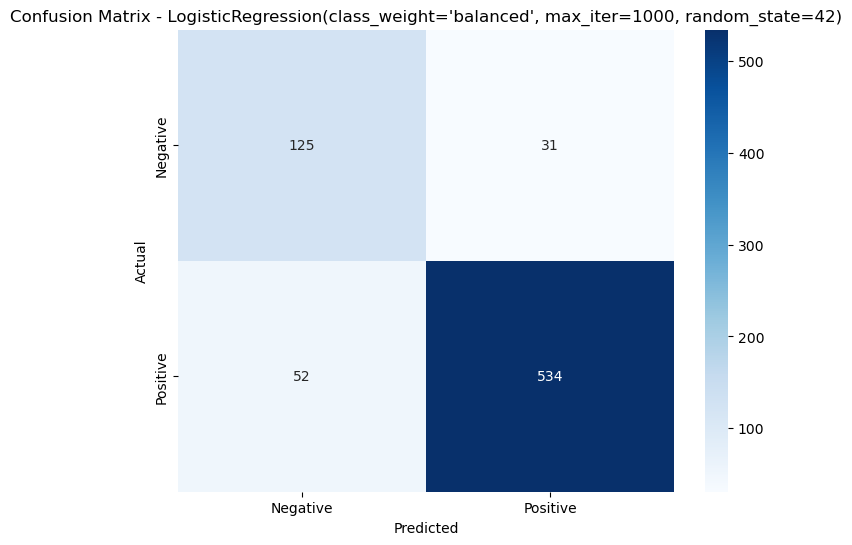


✅ Confusion matrix saved as 'confusion_matrix.png'


In [18]:
# Cell 12: Confusion Matrix
y_pred_final = final_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {final_model}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Confusion matrix saved as 'confusion_matrix.png'")

In [31]:
#“Word2Vec and BERT were considered. However, due to small dataset size and the effectiveness of TF-IDF with classical models, they were not implemented to avoid unnecessary complexity and overfitting.”